In [1]:
import os
import pandas as pd
import seaborn as sns
from fitting.utils import get_output_dirs, get_best_model_version

sns.set_style('white')
sns.set_context('poster')

### plot train/val losses as a function of epochs

In [13]:
metrics_df = []

# labs = ['steinmetz', 'steinmetz-face', 'musall', 'datta']
labs = ['datta']
model_types = ['conv', 'linear']
hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'experiment_name': 'test_tf',
    'model_class': 'ae'}

for lab in labs:
    get_lab_example(hparams, lab)
    if lab == 'datta':
        hparams['experiment_name'] = 'test_tf0'
    else:
        hparams['experiment_name'] = 'test_tf'
    for model_type in model_types:
        hparams['model_type'] = model_type     
        _, _, expt_dir = get_output_dirs(hparams)
        model_version = get_best_model_version(expt_dir)
        metric_file = os.path.join(expt_dir, model_version[0], 'metrics.csv')
        metrics = pd.read_csv(metric_file)
        for i, row in metrics.iterrows():
            metrics_df.append(pd.DataFrame({
                'epoch': row['epoch'],
                'loss': row['val_loss'],
                'dtype': 'val',
                'model_type': model_type,
                'data': lab
            }, index=[0]))
            metrics_df.append(pd.DataFrame({
                'epoch': row['epoch'],
                'loss': row['tr_loss'],
                'dtype': 'train',
                'model_type': model_type,
                'data': lab
            }, index=[0]))
            if 'test_loss' in row:
                metrics_df.append(pd.DataFrame({
                    'epoch': row['epoch'],
                    'loss': row['test_loss'],
                    'dtype': 'test',
                    'model_type': model_type,
                    'data': lab
                }, index=[0]))
metrics_df = pd.concat(metrics_df)    

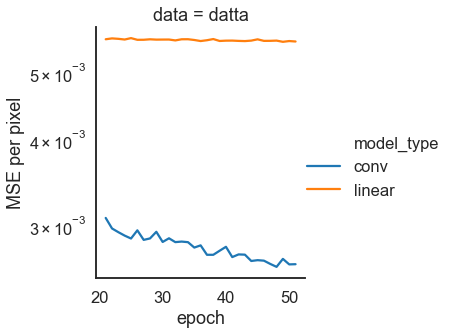

In [14]:
sns.set_style('white')
sns.set_context('talk')

# data_queried = metrics[~pd.notna(metrics.test_loss)]
data_queried = metrics_df[(metrics_df.dtype=='val') & (metrics_df.epoch>20)]
y_axis = 'loss' # 'test_loss' | 'test_r2'
plot_type = 'line'
hue = 'model_type'
x_axis = 'epoch' # 'layers' | 'layer_size' | 'pred' | 'lags'
col = 'data'

splt = sns.relplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, col=col, data=data_queried)
for i, ax in enumerate(splt.axes):
    ax[0].set_yscale('log')
    if i == 0:
        ax[0].set_ylabel('MSE per pixel')

In [ ]:
data_queried = metrics_df[metrics_df.dtype=='test']
y_axis = 'loss' # 'test_loss' | 'test_r2'
plot_type = 'boxen'
hue = 'model_type'
x_axis = 'data' # 'layers' | 'layer_size' | 'pred' | 'lags'

splt = sns.catplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=data_queried)
for i, ax in enumerate(splt.axes):
    ax[0].set_yscale('log')
    if i == 0:
        ax[0].set_ylabel('MSE per pixel')

### plot test losses as a function of latents

In [ ]:
metrics_df = []

hparams['experiment_name'] = 'best'
labs = ['musall']
model_types = ['conv', 'linear']
n_latents = [4, 8, 12, 16, 24, 64]

for lab in labs:
    get_lab_example(hparams, lab)
    for model_type in model_types:
        hparams['model_type'] = model_type
        for n_ae_latents in n_latents:
            hparams['n_ae_latents'] = n_ae_latents
            _, _, expt_dir = get_output_dirs(hparams)
            model_version = get_best_model_version(expt_dir)
            metric_file = os.path.join(expt_dir, model_version[0], 'metrics.csv')
            metrics = pd.read_csv(metric_file)
            for i, row in metrics.iterrows():
                metrics_df.append(pd.DataFrame({
                    'epoch': row['epoch'],
                    'loss': row['val_loss'],
                    'n_latents': n_ae_latents,
                    'dtype': 'val',
                    'model_type': model_type,
                    'data': lab
                }, index=[0]))
                metrics_df.append(pd.DataFrame({
                    'epoch': row['epoch'],use_output_mask
                    'loss': row['tr_loss'],
                    'n_latents': n_ae_latents,
                    'dtype': 'train',
                    'model_type': model_type,
                    'data': lab
                }, index=[0]))
                if 'test_loss' in row:
                    metrics_df.append(pd.DataFrame({
                        'epoch': row['epoch'],
                        'loss': row['test_loss'],
                        'n_latents': n_ae_latents,
                        'dtype': 'test',
                        'model_type': model_type,
                        'data': lab
                    }, index=[0]))
metrics_df = pd.concat(metrics_df)    

In [ ]:
# data_queried = metrics[~pd.notna(metrics.test_loss)]
data_queried = metrics_df[metrics_df.dtype=='test']
y_axis = 'loss' # 'test_loss' | 'test_r2'
plot_type = 'line'
hue = 'model_type'
x_axis = 'n_latents' # 'layers' | 'layer_size' | 'pred' | 'lags'

splt = sns.relplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=data_queried)
for i, ax in enumerate(splt.axes):
    ax[0].set_yscale('log')
    if i == 0:
        ax[0].set_ylabel('MSE per pixel')

### make movie

Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe/mouse-01/session-01/ae/conv/12_latents/test_tube_data/test_pt/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe/mouse-01/session-01/ae/linear/12_latents/test_tube_data/test_pt/version_0/meta_tags.pkl
video saved to /home/mattw/results/temp/steinmetz_+linear_test_pt.mp4
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe-face/mouse-01/session-01/ae/conv/12_latents/test_tube_data/test_pt/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe-face/mouse-01/session-01/ae/linear/12_latents/test_tube_data/test_pt/version_0/meta_tags.pkl
video saved to /home/mattw/results/temp/steinmetz-face_+linear_test_pt.mp4
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM30/10-Oct-2017/ae/conv/16_latents/test_tube_data/test_pt/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/beh

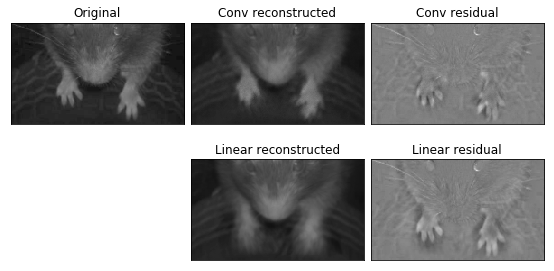

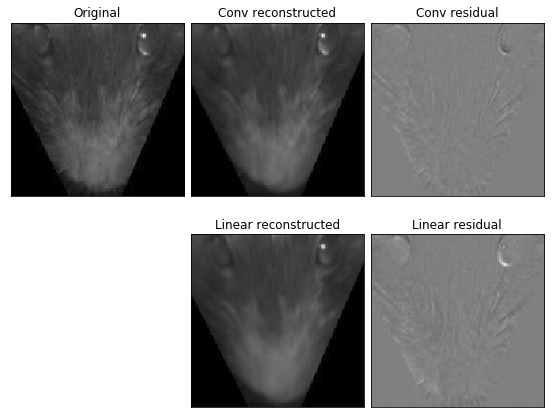

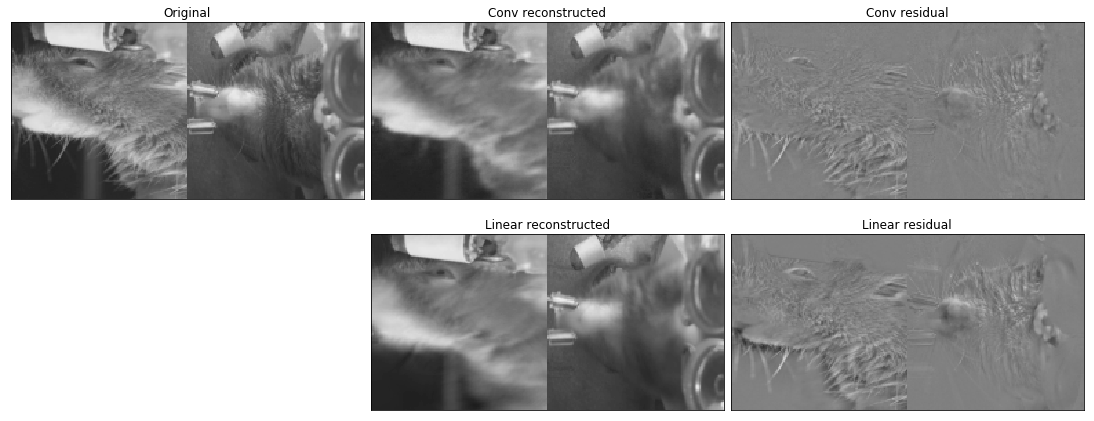

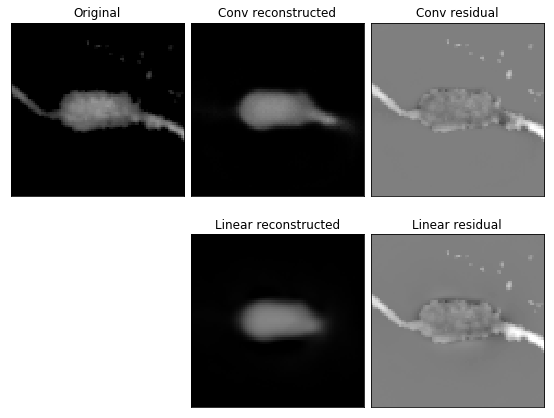

In [23]:
from analyses.ae.movies import reconstruction
from fitting.utils import get_lab_example
from data.data_generator import ConcatSessionsGenerator
include_linear = True
version = 'best'
hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'experiment_name': 'test_pt',
    'model_class': 'ae',
    'model_type': 'conv',
    'lib': 'pt'}

labs = ['steinmetz', 'steinmetz-face', 'musall', 'datta']

for lab in labs:
    get_lab_example(hparams, lab)
    data_generator = ConcatSessionsGenerator(
        hparams['data_dir'], hparams, 
        signals=['images'], transforms=[None], load_kwargs=[None],
        device='cpu', as_numpy=False, batch_load=True, rng_seed=0)
    trial = data_generator.batch_indxs[0]['test'][4]

    save_file = str('/home/mattw/results/temp/%s' % lab)
    if include_linear:
        save_file += '_+linear'
    save_file += '_%s' % hparams['experiment_name']

    reconstruction(
        hparams, version=version, save_file=save_file, include_linear=include_linear,
        trial=trial)

In [7]:
# find good trials
from fitting.utils import get_data_generator_inputs
from fitting.utils import get_lab_example
from data.data_generator import ConcatSessionsGenerator
hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'experiment_name': 'test_pt',
    'model_class': 'ae',
    'model_type': 'conv',
    'lib': 'pt'}
hparams['model_class'] = 'neural-ae'
hparams['neural_thresh'] = 1.0
hparams['neural_type'] = 'spikes'
hparams['neural_bin_size'] = 10
hparams['ae_experiment_name'] = 'test_pt'
hparams['ae_version'] = 'best'
get_lab_example(hparams, 'steinmetz')
hparams, signals, transforms, load_kwargs = get_data_generator_inputs(hparams)
data_generator = ConcatSessionsGenerator(
    hparams['data_dir'], hparams, 
    signals=signals, transforms=transforms, load_kwargs=load_kwargs,
    device='cpu', as_numpy=False, batch_load=False, rng_seed=0)

neural
None
ae
None
{'model_dir': '/home/mattw/results/behavenet/steinmetz/2-probe/mouse-01/session-01/ae/conv/12_latents/test_tube_data/test_pt', 'model_version': 'best'}


In [21]:
trial = data_generator.batch_indxs[0]['test'][5]
data = data_generator.datasets[0][trial]
import matplotlib.pyplot as plt
plt.figure()
plt.plot(data['ae'].cpu().detach().numpy())
plt.show()

KeyError: 'ae'

<Figure size 432x288 with 0 Axes>

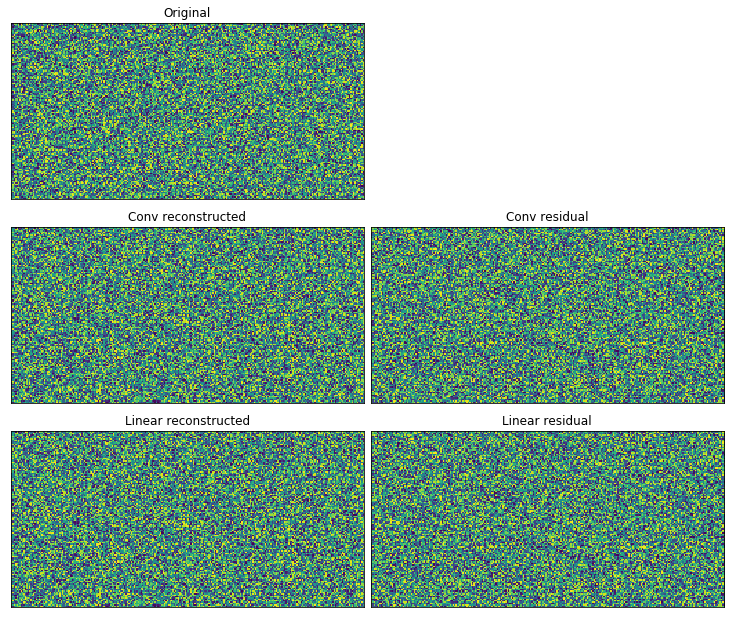

In [38]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

ims_recon_lin = 0

ims_orig = np.random.rand(4, 1, 128, 256)
n_channels, y_pix, x_pix = ims_orig.shape[1:]
n_channels = 2
x_pix = 128

# ims_orig = np.random.rand(4, 1, 112, 192)
# n_channels, y_pix, x_pix = ims_orig.shape[1:]

# ims_orig = np.random.rand(4, 1, 80, 80)
# n_channels, y_pix, x_pix = ims_orig.shape[1:]

n_cols = 3 if ims_recon_lin is None else 2
n_rows = 1 if ims_recon_lin is None else 2
scale_ = 5
fig_width = scale_ * n_cols * n_channels / 2
fig_height = y_pix / x_pix * scale_ * n_rows / 2
offset = 0 if ims_recon_lin is None else 1
fig = plt.figure(figsize=(fig_width, fig_height + offset))
# title = 'Behavorial video compression'
# fig.suptitle(title, fontsize=16)

gs = GridSpec(n_rows, n_cols, figure=fig)
axs = []
if ims_recon_lin is None:
    axs.append(fig.add_subplot(gs[0, 0]))  # 0: original frames
    axs.append(fig.add_subplot(gs[0, 1]))  # 1: cae reconstructed frames
    axs.append(fig.add_subplot(gs[0, 2]))  # 2: cae residuals
else:
    axs.append(fig.add_subplot(gs[0, 0]))  # 0: original frames
    axs.append(fig.add_subplot(gs[1, 0]))  # 1: cae reconstructed frames
    axs.append(fig.add_subplot(gs[1, 1]))  # 2: cae residuals
    axs.append(fig.add_subplot(gs[2, 0]))  # 3: linear reconstructed frames
    axs.append(fig.add_subplot(gs[2, 1]))  # 4: linear residuals
for ax in fig.axes:
    ax.set_xticks([])
    ax.set_yticks([])
        
fontsize = 12
axs[0].set_title('Original', fontsize=fontsize)
axs[1].set_title('Conv reconstructed', fontsize=fontsize)
axs[2].set_title('Conv residual', fontsize=fontsize)
if ims_recon_lin is not None:
    axs[3].set_title('Linear reconstructed', fontsize=fontsize)
    axs[4].set_title('Linear residual', fontsize=fontsize)
    
axs[0].imshow(ims_orig[0, 0])
axs[1].imshow(ims_orig[1, 0])
axs[2].imshow(ims_orig[2, 0])
if ims_recon_lin is not None:
    axs[3].imshow(ims_orig[1, 0])
    axs[4].imshow(ims_orig[2, 0])
    
plt.tight_layout(pad=0)
plt.show()

In [27]:
hparams

{'data_dir': '/home/mattw/data',
 'tt_save_path': '/home/mattw/results/behavenet',
 'experiment_name': 'test_pt',
 'model_class': 'ae',
 'model_type': 'conv',
 'lib': 'pt',
 'lab': 'datta',
 'expt': 'inscopix',
 'animal': '15566',
 'session': '2018-11-27',
 'n_ae_latents': 8,
 'use_output_mask': True}

In [26]:
data_generator = ConcatSessionsGenerator(
    hparams['data_dir'], hparams, 
    signals=['neural'], transforms=[None], load_kwargs=[None],
    device='cpu', as_numpy=False, batch_load=False, rng_seed=0)

KeyError: 'reg_indxs'

In [ ]:
data_generator.datasets[0].batch_indxs['train']

In [24]:
data_generator.batch_indxs[0]['train']

array([60, 61, 62, 63, 64, 20, 21, 22, 23, 24, 10, 11, 12, 13, 14, 40, 41,
       42, 43, 44, 30, 31, 32, 33, 34,  0,  1,  2,  3,  4, 50, 51, 52, 53,
       54])

In [18]:
batch = data_generator.datasets[0][60]

In [20]:
batch['images'].shape

torch.Size([1000, 1, 80, 80])